<a href="https://colab.research.google.com/github/iffigueroa/text-marketing-analytics/blob/main/dtsa_5798_supervised_text_classification_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5798 Project

In [1]:
import os
try:
  import ktrain
  print(ktrain.__version__)
except:
  !pip install ktrain
  os.kill(os.getpid(), 9)

from ktrain import text
from ktrain.text import texts_from_df
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

0.41.2


## Load the Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

PATH = "/content/drive/MyDrive/MSDS_marketing_text_analytics/master_files/1_text_classification"
reviews = pd.read_json(f'{PATH}/news_category_trainingdata.json')

Mounted at /content/drive


## Exploration

In [3]:
reviews.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [4]:
print(f"{reviews.shape[0]} reviews with {reviews.shape[1]} attributes available, including:\n")
attributes = "\n".join(reviews.columns)
print(f"{attributes}")

200853 reviews with 6 attributes available, including:

category
headline
authors
link
short_description
date


In [5]:
all_categories = "\n".join(reviews['category'].unique())
print(all_categories)

CRIME
ENTERTAINMENT
WORLD NEWS
IMPACT
POLITICS
WEIRD NEWS
BLACK VOICES
WOMEN
COMEDY
QUEER VOICES
SPORTS
BUSINESS
TRAVEL
MEDIA
TECH
RELIGION
SCIENCE
LATINO VOICES
EDUCATION
COLLEGE
PARENTS
ARTS & CULTURE
STYLE
GREEN
TASTE
HEALTHY LIVING
THE WORLDPOST
GOOD NEWS
WORLDPOST
FIFTY
ARTS
WELLNESS
PARENTING
HOME & LIVING
STYLE & BEAUTY
DIVORCE
WEDDINGS
FOOD & DRINK
MONEY
ENVIRONMENT
CULTURE & ARTS


In [6]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 10.7+ MB


In [7]:
# # Convert date to date
# reviews['date'] = pd.to_datetime(reviews['date'])

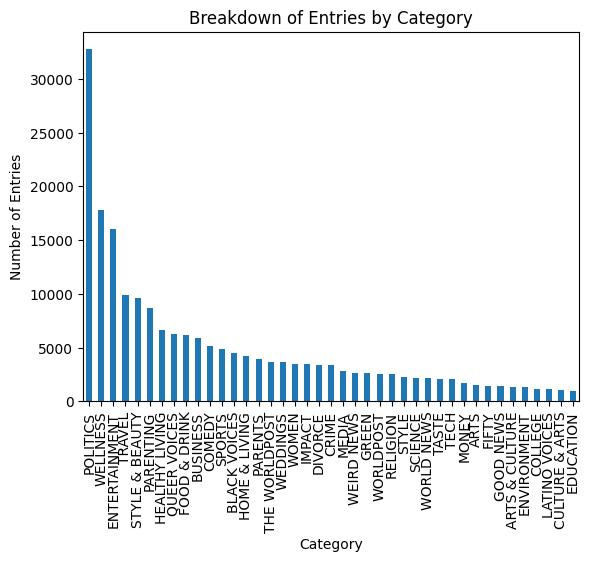

In [8]:
# Plot breakdown of entries by category
reviews['category'].value_counts().plot(kind='bar', title='Breakdown of Entries by Category')
plt.xlabel('Category')
plt.ylabel('Number of Entries')
plt.show()

In [9]:
def plot_category_by_date(df, category):

    # Filter DataFrame for the specified category
    if isinstance(category, list):
      filtered = df[df['category'].isin(category)]
      print(filtered.shape)
      grouped_data = filtered.groupby([pd.Grouper(key="date", freq='M'), 'category']).size().unstack()
    else:
      filtered = df[df['category'] == category]
      grouped_data = filtered.groupby(pd.Grouper(key="date", freq='M')).size()

    # Group by month and plot
    grouped_data.plot(kind='bar', figsize=(12, 6), title='Entries by Date and Category')
    plt.xlabel('Month')
    plt.ylabel('Number of Entries')
    plt.title(f'Articles tagged as "{category}" by Month')
    plt.show()

(24521, 6)


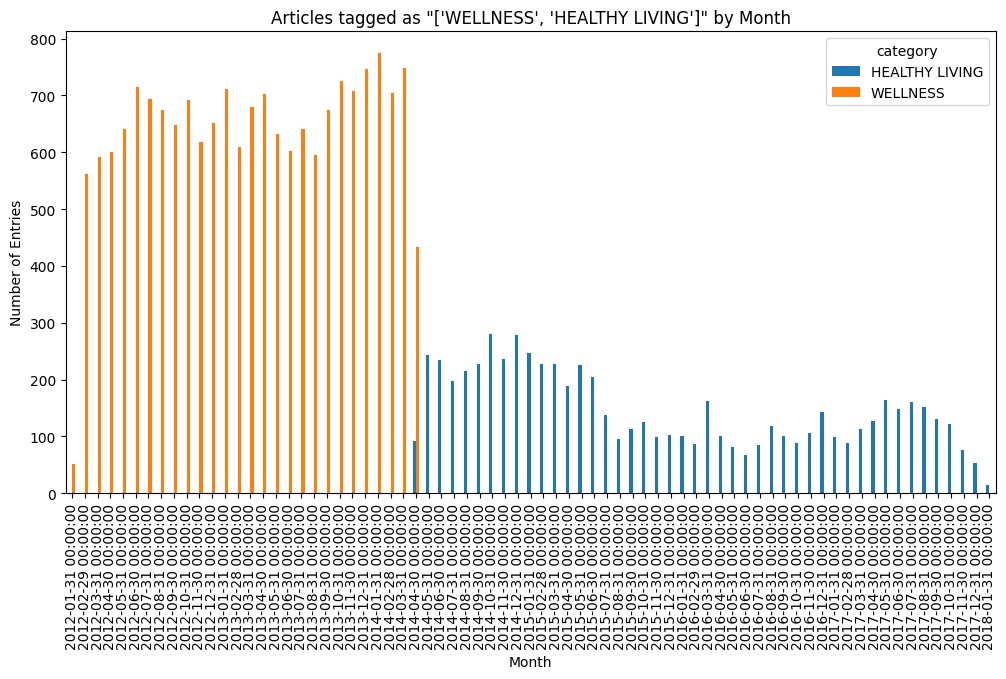

In [10]:
plot_category_by_date(reviews, ["WELLNESS", "HEALTHY LIVING"])

## Pre Processing

In [11]:
reviews['all_text'] = reviews['headline'] + ' ' + reviews['short_description']

In [12]:
from string import punctuation

def clean_text(text):
  """Do some basic cleaning - preprocess methods later will help later"""
  cleaned_text = ''.join([char for char in text if char not in punctuation])
  return cleaned_text.lower()

reviews['all_text'].apply(clean_text)


0         there were 2 mass shootings in texas last week...
1         will smith joins diplo and nicky jam for the 2...
2         hugh grant marries for the first time at age 5...
3         jim carrey blasts castrato adam schiff and dem...
4         julianna margulies uses donald trump poop bags...
                                ...                        
200848    rim ceo thorsten heins significant plans for b...
200849    maria sharapova stunned by victoria azarenka i...
200850    giants over patriots jets over colts among  mo...
200851    aldon smith arrested 49ers linebacker busted f...
200852    dwight howard rips teammates after magic loss ...
Name: all_text, Length: 200853, dtype: object

In [13]:
reviews['health_and_wellness'] = np.where((reviews['category'].isin(["HEALTHY LIVING", "WELLNESS"])), 1, 0)
reviews['health_and_wellness'].describe()

count    200853.000000
mean          0.122084
std           0.327384
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: health_and_wellness, dtype: float64

In [14]:
value_counts = reviews['health_and_wellness'].value_counts()
value_counts.head()

0    176332
1     24521
Name: health_and_wellness, dtype: int64

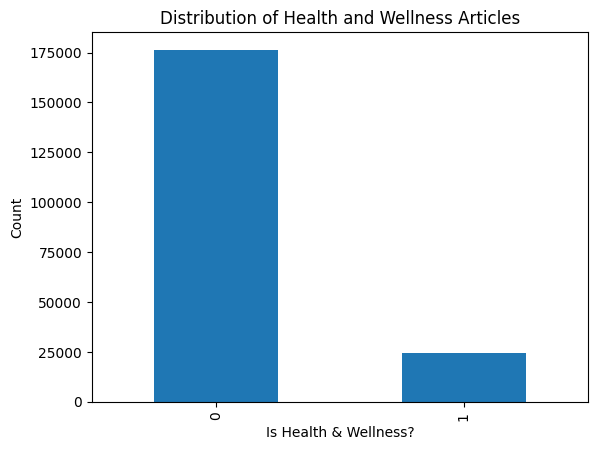

In [15]:
value_counts.plot(kind='bar')
plt.xlabel('Is Health & Wellness?')
plt.ylabel('Count')
plt.title('Distribution of Health and Wellness Articles')
plt.show()

In [16]:
reviews.drop(['category', 'headline', 'authors', 'link', 'short_description', 'date'], axis=1, inplace=True)

Need a more even distribution:

In [17]:
sample_amount = 5000

health_and_wellness = reviews[reviews['health_and_wellness'] == 1].sample(n=sample_amount)
not_health_and_wellness = reviews[reviews['health_and_wellness'] == 0].sample(n=sample_amount)
print(health_and_wellness.shape)
print(not_health_and_wellness.shape)

(5000, 2)
(5000, 2)


# Model Building

## Baseline Model with Distilbert

In [18]:
# tf.keras.backend.clear_session()
# target_names = ['NOT HEALTH & WELLNESS','HEALTH & WELLNESS']

In [19]:
review_sample = pd.concat([health_and_wellness,not_health_and_wellness])

In [20]:
train, val, preprocess = texts_from_df(
    review_sample,
    'all_text',
    label_columns=['health_and_wellness'],
    val_df=None,
    max_features=10000,
    maxlen=512,
    val_pct=0.1,
    ngram_range=1,
    preprocess_mode='distilbert',
    verbose=1
)


['not_health_and_wellness', 'health_and_wellness']
        not_health_and_wellness  health_and_wellness
14182                       0.0                  1.0
148359                      0.0                  1.0
139712                      0.0                  1.0
84069                       0.0                  1.0
97475                       1.0                  0.0
['not_health_and_wellness', 'health_and_wellness']
        not_health_and_wellness  health_and_wellness
25732                       1.0                  0.0
159522                      1.0                  0.0
160163                      1.0                  0.0
38634                       0.0                  1.0
118629                      0.0                  1.0


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

preprocessing train...
language: en
train sequence lengths:
	mean : 32
	95percentile : 58
	99percentile : 68


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 31
	95percentile : 57
	99percentile : 67


In [21]:
model = preprocess.get_classifier()
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=16)

In [22]:
learner.lr_find(max_epochs=6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/6
562/562 [==============================] - 538s 877ms/step - loss: 0.6616 - accuracy: 0.6122
Epoch 2/6
562/562 [==============================] - 508s 904ms/step - loss: 0.2936 - accuracy: 0.8895
Epoch 3/6
562/562 [==============================] - 506s 900ms/step - loss: 0.4018 - accuracy: 0.7905
Epoch 4/6
562/562 [==============================] - 502s 894ms/step - loss: 0.6978 - accuracy: 0.5056
Epoch 5/6
562/562 [==============================] - 219s 389ms/step - loss: 8.0232 - accuracy: 0.5013


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


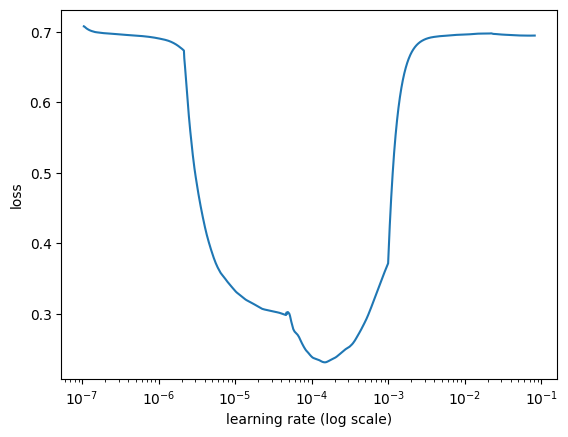

In [23]:
learner.lr_plot()

In [24]:
history=learner.autofit(1e-4,checkpoint_folder='checkpoint',epochs=12, early_stopping=True)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/12
563/563 [==============================] - 539s 916ms/step - loss: 0.3079 - accuracy: 0.8769 - val_loss: 0.2043 - val_accuracy: 0.9090
Epoch 2/12
563/563 [==============================] - 511s 907ms/step - loss: 0.1364 - accuracy: 0.9518 - val_loss: 0.2221 - val_accuracy: 0.9140
Epoch 2: early stopping
Weights from best epoch have been loaded into model.


In [25]:
learner.save_model(f"{PATH}/distilbertmodel_learner")

In [26]:
predictor = ktrain.get_predictor(learner.model, preproc=preprocess)
predictor.save(f"{PATH}/distilbertmodel_predictor")

In [27]:
validation = learner.validate(val_data=val, print_report=True)

32/32 [==============================] - 8s 141ms/step
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       521
           1       0.91      0.90      0.90       479

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



## Additional Preprocessing Methods



In [35]:
learners = {}

train, val, preprocess = texts_from_df(
    review_sample,
    'all_text',
    label_columns=['health_and_wellness'],
    val_df=None,
    max_features=10000,
    maxlen=512,
    val_pct=0.1,
    ngram_range=1,
    preprocess_mode='standard',
    verbose=1
)

def train_with_model(model: str, epochs: int = 10):
  model = ktrain.text.text_classifier(model, train , preproc=preprocess)
  learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=16)
  learner.lr_find(max_epochs=epochs)

  learner.lr_plot()
  optimal_lr = learner.lr_estimate()
  print(f"Optimal LR: {min(optimal_lr)}")
  history=learner.autofit(min(optimal_lr),checkpoint_folder='checkpoint',epochs=12, early_stopping=True)
  learner.save_model(f"{PATH}/{model}_learner")
  predictor = ktrain.get_predictor(learner.model, preproc=preprocess)
  predictor.save(f"{PATH}/{model}_predictor")
  return learner

['not_health_and_wellness', 'health_and_wellness']
        not_health_and_wellness  health_and_wellness
102009                      1.0                  0.0
62754                       1.0                  0.0
129411                      0.0                  1.0
103801                      1.0                  0.0
200664                      1.0                  0.0
['not_health_and_wellness', 'health_and_wellness']
        not_health_and_wellness  health_and_wellness
160163                      1.0                  0.0
111837                      0.0                  1.0
98800                       1.0                  0.0
170657                      0.0                  1.0
176236                      1.0                  0.0
language: en
Word Counts: 24465
Nrows: 9000
9000 train sequences
train sequence lengths:
	mean : 31
	95percentile : 56
	99percentile : 67
x_train shape: (9000,512)
y_train shape: (9000, 2)
Is Multi-Label? False
1000 test sequences
test sequence lengths:
	mean : 

Is Multi-Label? False
compiling word ID features...
maxlen is 512
done.
simulating training for different learning rates... this may take a few moments...


/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/10
563/563 [==============================] - 8s 9ms/step - loss: 0.9148 - accuracy: 0.4896
Epoch 2/10
563/563 [==============================] - 4s 8ms/step - loss: 0.8891 - accuracy: 0.5021
Epoch 3/10
563/563 [==============================] - 5s 9ms/step - loss: 0.8983 - accuracy: 0.4974
Epoch 4/10
563/563 [==============================] - 6s 11ms/step - loss: 0.8450 - accuracy: 0.5109
Epoch 5/10
563/563 [==============================] - 4s 7ms/step - loss: 0.7286 - accuracy: 0.5739
Epoch 6/10
563/563 [==============================] - 4s 7ms/step - loss: 0.5226 - accuracy: 0.7490
Epoch 7/10
563/563 [==============================] - 5s 9ms/step - loss: 0.5051 - accuracy: 0.7686
Epoch 8/10
563/563 [==============================] - 4s 7ms/step - loss: 0.6817 - accuracy: 0.5474
Epoch 9/10
563/563 [==============================] - 4s 8ms/step - loss: 0.7275 - accuracy: 0.4926
Epoch 10/10
563/563 [==============================] - 5s 9ms/step - loss: 1.0398 - accuracy: 0.496

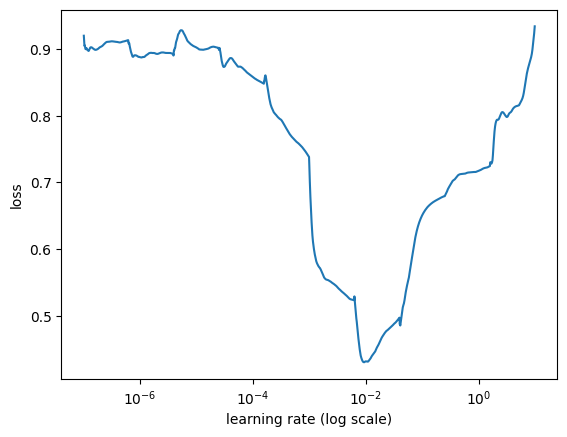

Optimal LR: 0.0004327469505369663


begin training using triangular learning rate policy with max lr of 0.00043274695...
Epoch 1/12
563/563 [==============================] - 8s 12ms/step - loss: 0.8169 - accuracy: 0.5260 - val_loss: 0.6598 - val_accuracy: 0.7250
Epoch 2/12
563/563 [==============================] - 4s 7ms/step - loss: 0.6877 - accuracy: 0.6051 - val_loss: 0.5662 - val_accuracy: 0.7760
Epoch 3/12
563/563 [==============================] - 4s 7ms/step - loss: 0.5914 - accuracy: 0.6854 - val_loss: 0.4759 - val_accuracy: 0.8090
Epoch 4/12
563/563 [==============================] - 4s 7ms/step - loss: 0.5098 - accuracy: 0.7487 - val_loss: 0.4075 - val_accuracy: 0.8420
Epoch 5/12
563/563 [==============================] - 3s 6ms/step - loss: 0.4290 - accuracy: 0.8074 - val_loss: 0.3642 - val_accuracy: 0.8520
Epoch 6/12
563/563 [==============================] - 3s 6ms/step - loss: 0.3842 - accuracy: 0.8348 - val_loss: 0.3392 - val_accuracy: 0.8500
Epoch 7/12
563/563 [======

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
fasttext_learner = train_with_model('fasttext')
learners['fasttext'] = fasttext_learner

Is Multi-Label? False
compiling word ID features...
maxlen is 512
building document-term matrix... this may take a few moments...
rows: 1-9000
computing log-count ratios...
done.
simulating training for different learning rates... this may take a few moments...
Epoch 1/10
563/563 [==============================] - 3s 4ms/step - loss: 0.6961 - accuracy: 0.5010
Epoch 2/10
563/563 [==============================] - 3s 5ms/step - loss: 0.6944 - accuracy: 0.5061
Epoch 3/10
563/563 [==============================] - 2s 4ms/step - loss: 0.6860 - accuracy: 0.5353
Epoch 4/10
563/563 [==============================] - 2s 4ms/step - loss: 0.6461 - accuracy: 0.6338
Epoch 5/10
563/563 [==============================] - 2s 4ms/step - loss: 0.5237 - accuracy: 0.8042
Epoch 6/10
563/563 [==============================] - 2s 4ms/step - loss: 0.3364 - accuracy: 0.9026
Epoch 7/10
563/563 [==============================] - 3s 5ms/step - loss: 0.2301 - accuracy: 0.9207
Epoch 8/10
563/563 [==================

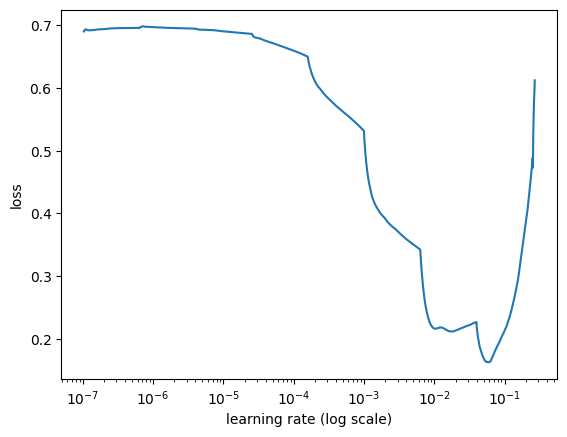

Optimal LR: 0.00044567944132722914


begin training using triangular learning rate policy with max lr of 0.00044567944...
Epoch 1/12
563/563 [==============================] - 3s 5ms/step - loss: 0.5970 - accuracy: 0.6932 - val_loss: 0.5376 - val_accuracy: 0.7700
Epoch 2/12
563/563 [==============================] - 3s 6ms/step - loss: 0.4748 - accuracy: 0.8482 - val_loss: 0.4680 - val_accuracy: 0.8230
Epoch 3/12
563/563 [==============================] - 3s 6ms/step - loss: 0.4080 - accuracy: 0.8877 - val_loss: 0.4254 - val_accuracy: 0.8540
Epoch 4/12
563/563 [==============================] - 3s 5ms/step - loss: 0.3632 - accuracy: 0.9022 - val_loss: 0.3962 - val_accuracy: 0.8710
Epoch 5/12
563/563 [==============================] - 3s 5ms/step - loss: 0.3306 - accuracy: 0.9123 - val_loss: 0.3754 - val_accuracy: 0.8770
Epoch 6/12
563/563 [==============================] - 3s 5ms/step - loss: 0.3054 - accuracy: 0.9194 - val_loss: 0.3598 - val_accuracy: 0.8790
Epoch 7/12
563/563 [======

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
nbsvm_learner = train_with_model('nbsvm')
learners['nbsvm'] = nbsvm_learner

Is Multi-Label? False
compiling word ID features...
maxlen is 512
done.
simulating training for different learning rates... this may take a few moments...
Epoch 1/10
563/563 [==============================] - 3s 4ms/step - loss: 0.6953 - accuracy: 0.5106
Epoch 2/10
563/563 [==============================] - 2s 4ms/step - loss: 0.6937 - accuracy: 0.5199
Epoch 3/10
563/563 [==============================] - 2s 4ms/step - loss: 0.6864 - accuracy: 0.5622
Epoch 4/10
563/563 [==============================] - 2s 4ms/step - loss: 0.6565 - accuracy: 0.6471
Epoch 5/10
563/563 [==============================] - 3s 4ms/step - loss: 0.5649 - accuracy: 0.7798
Epoch 6/10
563/563 [==============================] - 3s 5ms/step - loss: 0.3933 - accuracy: 0.8720
Epoch 7/10
563/563 [==============================] - 2s 4ms/step - loss: 0.2868 - accuracy: 0.8960
Epoch 8/10
563/563 [==============================] - 2s 4ms/step - loss: 1.0634 - accuracy: 0.8426
Epoch 9/10
563/563 [=========================

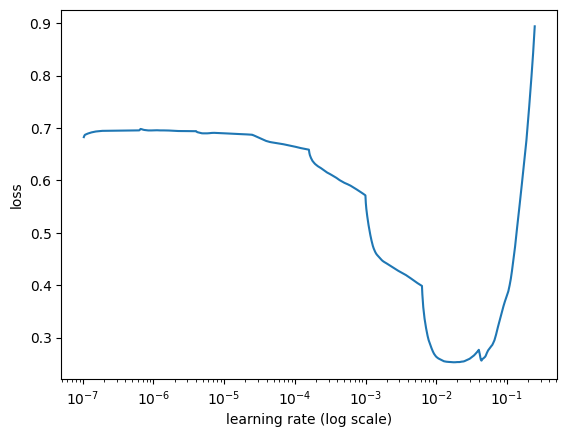

Optimal LR: 0.00019223662093281746


begin training using triangular learning rate policy with max lr of 0.00019223662...
Epoch 1/12
563/563 [==============================] - 4s 7ms/step - loss: 0.6551 - accuracy: 0.6352 - val_loss: 0.6242 - val_accuracy: 0.6790
Epoch 2/12
563/563 [==============================] - 3s 5ms/step - loss: 0.5966 - accuracy: 0.7512 - val_loss: 0.5830 - val_accuracy: 0.7610
Epoch 3/12
563/563 [==============================] - 3s 5ms/step - loss: 0.5533 - accuracy: 0.8072 - val_loss: 0.5506 - val_accuracy: 0.7880
Epoch 4/12
563/563 [==============================] - 3s 5ms/step - loss: 0.5182 - accuracy: 0.8316 - val_loss: 0.5243 - val_accuracy: 0.8170
Epoch 5/12
563/563 [==============================] - 3s 5ms/step - loss: 0.4886 - accuracy: 0.8500 - val_loss: 0.5021 - val_accuracy: 0.8290
Epoch 6/12
563/563 [==============================] - 3s 6ms/step - loss: 0.4632 - accuracy: 0.8614 - val_loss: 0.4832 - val_accuracy: 0.8310
Epoch 7/12
563/563 [======

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
logreg_learner = train_with_model('logreg')
learners['logreg'] = logreg_learner

# Validation

In [39]:
for model in learners:
  print(f"Validation for model {model}")
  learners[model].validate(val_data=val, print_report=True)

Validation for model fasttext
32/32 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       501
           1       0.87      0.87      0.87       499

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000

Validation for model nbsvm
32/32 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.91      0.84      0.87       501
           1       0.85      0.92      0.88       499

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000

Validation for model logreg
32/32 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.90      0.81      0.86    

# Conclusions